/home/deepthi/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


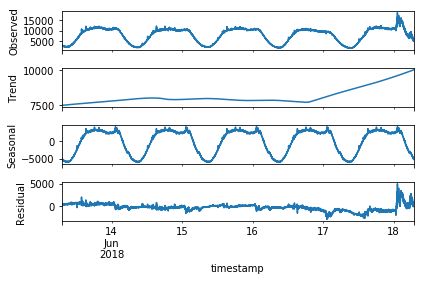

In [1]:
import os
import pandas as pd
import numpy as np
from stldecompose import decompose
import time


path = os.getcwd()
files = os.listdir(path)
files_xls = [f for f in files if f[-3:] == 'xls']
allFiles = pd.DataFrame()
data = pd.read_excel('June13data.xls')
allFiles = allFiles.append(data)
data = pd.read_excel('June14data.xls')
allFiles = allFiles.append(data)
data = pd.read_excel('June15data.xls')
allFiles = allFiles.append(data)
data = pd.read_excel('June16data.xls')
allFiles = allFiles.append(data)
data = pd.read_excel('June17data.xls')
allFiles = allFiles.append(data)
#Set the index of the data as the timestamp
allFiles = allFiles.set_index(pd.DatetimeIndex(allFiles['timestamp']))

#Resample the data so that the data is continuous my Minute
resampledData = pd.DataFrame()
resampledData = (allFiles.resample('Min').mean().interpolate('linear'))

#Do STL Decomposition on the data with the period of 24*60
stl = decompose(resampledData, period=1440)
stl.plot()

In [2]:
residualData = pd.DataFrame();
residualData = stl.resid

#compute the mean of the residual value
m = residualData['value'].mean();

#subtract the mean value from the data to normalize it
residualData['mvalue'] = abs(residualData['value']-m);

#compute the standard deviation of the residual data nad divide the absolute value by it
s = np.std(residualData.value, axis=0, ddof=0)
residualData['sd']= residualData['mvalue']/s

#filter the data with the standard deviation more than 3.
filteredData = pd.DataFrame()
filteredData = residualData.loc[residualData['sd'] > 3]

#function to identify difference between 2 datetimes
def diffdates(d1, d2):
    return (time.mktime(time.strptime(d2,"%Y-%m-%d %H:%M:%S")) -
               time.mktime(time.strptime(d1, "%Y-%m-%d %H:%M:%S")))
count = 0
prev = "2018-06-13 07:00:00"
i = 0

#first anomalous data with points which are contiguous for 5 minutes
finalres = pd.DataFrame(pd.DataFrame(columns=['timestamp','residualValue']))
for index, row in filteredData.iterrows():
    diff = diffdates(str(index), prev)
    if abs(diff) == 60 and count <5:
        finalres.loc[i] = str(index),row['value']
        i=i+1
        count+=1
    elif count >= 5:
        print('Anomalous data point values')
        print(finalres)
        count = 0;
        i=0;
        break;
    else:
        finalres = pd.DataFrame(pd.DataFrame(columns=['timestamp','residualValue']))
        count = 0;
        i=0;
    prev = str(index)
    
    
print(" ")
dates = {"2018-06-13", "2018-06-14", "2018-06-15", "2018-06-16", "2018-06-17", "2018-06-18"}
print('Non - Anomalous dates')
finalres['timestamp'] = finalres['timestamp'].astype(str)

#print the non-anomalous date values
for d in dates:
    missingDate = finalres[finalres['timestamp'].str.contains(d)]
    if (missingDate.empty):
          print(d)   

Anomalous data point values
             timestamp  residualValue
0  2018-06-18 01:13:00    3302.719700
1  2018-06-18 01:14:00    2909.895278
2  2018-06-18 01:15:00    2191.070855
3  2018-06-18 01:16:00    2387.146433
4  2018-06-18 01:17:00    3548.722011
 
Non - Anomalous dates
2018-06-17
2018-06-13
2018-06-15
2018-06-16
2018-06-14
